# Disaster Tweet Prediction


                 For a beginner,Starting out in NLP is quite a challenge,atleast for me it was. This is such an emerging field that the developments are happening at a very rapid rate. So coping up in NLP would feel a bit difficult. I had to go through many resources and notebooks on Kaggle and GitHub in order to get a better understanding of the concepts and I did not have a clear roadmap as to how to proceed.This book is created in such a way that anyone starting out in the NLP would atleast get an idea of how to start and proceed. I have tried to touch upon the topics I felt should be known and the link to the resources for the topics are provided in the respective sections.

![](https://miro.medium.com/max/1838/1*ASL5AkBNLyIPPIf5pJp6Lg.jpeg)

## Importing the Libraries and the dataset

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py


In [2]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize,word_tokenize

In [3]:
df_train=pd.read_csv('../input/nlp-getting-started/train.csv')
df_test=pd.read_csv('../input/nlp-getting-started/test.csv')

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.shape

(7613, 5)

## EDA

##### missingno is a library that is used to visualize the missing values. The missing values can be visualized using barplot,matrix plot or heatmap. For reference you can visit this github page:
[https://github.com/ResidentMario/missingno](https://github.com/ResidentMario/missingno)

<AxesSubplot:>

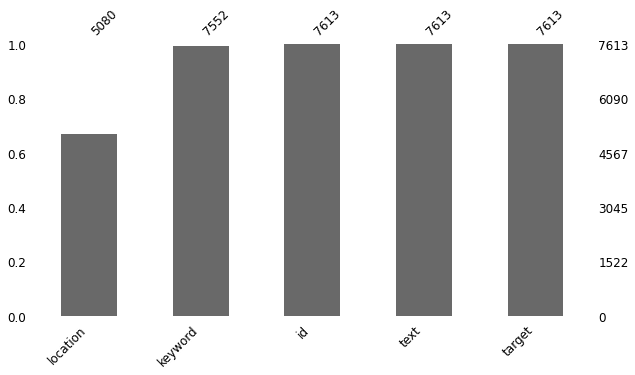

In [6]:
missingno.bar(df_train,sort="ascending", figsize=(10,5), fontsize=12)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

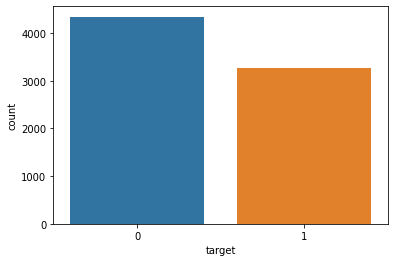

In [7]:
sns.countplot(df_train['target'])

<AxesSubplot:xlabel='location'>

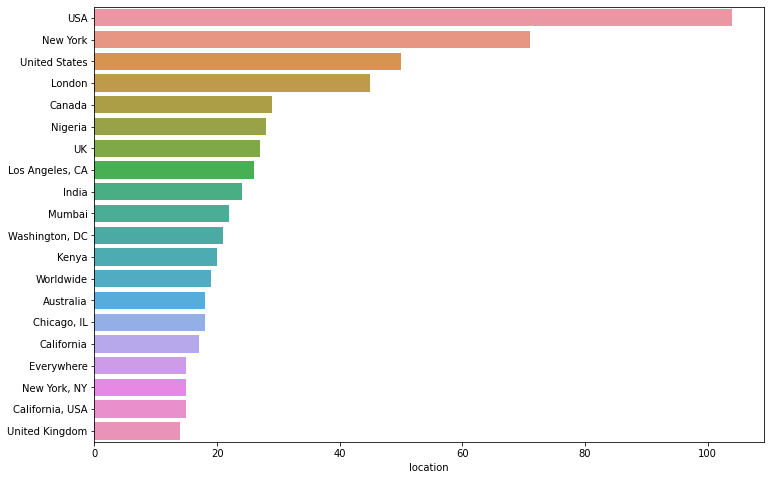

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_train['location'].value_counts()[:20],y=df_train['location'].value_counts()[:20].index)


In [9]:
len(df_train)

7613

In [10]:
df_train[df_train['target']==0]['location'].value_counts()[:20]


New York           55
USA                37
London             29
United States      23
Los Angeles, CA    18
Canada             16
Kenya              15
Everywhere         12
Florida            11
UK                 11
NYC                10
United Kingdom     10
California         10
ss                  9
Australia           9
Chicago, IL         9
304                 9
London, England     9
New York, NY        8
San Francisco       8
Name: location, dtype: int64

In [11]:
df_train[df_train['target']==0]['location'].value_counts()[:20].index


Index(['New York', 'USA', 'London', 'United States', 'Los Angeles, CA',
       'Canada', 'Kenya', 'Everywhere', 'Florida', 'UK', 'NYC',
       'United Kingdom', 'California', 'ss', 'Australia', 'Chicago, IL', '304',
       'London, England', 'New York, NY', 'San Francisco'],
      dtype='object')

## Top Location based on Tweets(Disaster or Non-Disaster)


[Text(0, 0, 'USA'),
 Text(0, 1, 'United States'),
 Text(0, 2, 'Nigeria'),
 Text(0, 3, 'India'),
 Text(0, 4, 'Mumbai'),
 Text(0, 5, 'London'),
 Text(0, 6, 'New York'),
 Text(0, 7, 'UK'),
 Text(0, 8, 'Washington, DC'),
 Text(0, 9, 'Canada'),
 Text(0, 10, 'Worldwide'),
 Text(0, 11, 'Chicago, IL'),
 Text(0, 12, 'Australia'),
 Text(0, 13, 'Washington, D.C.'),
 Text(0, 14, 'Earth')]

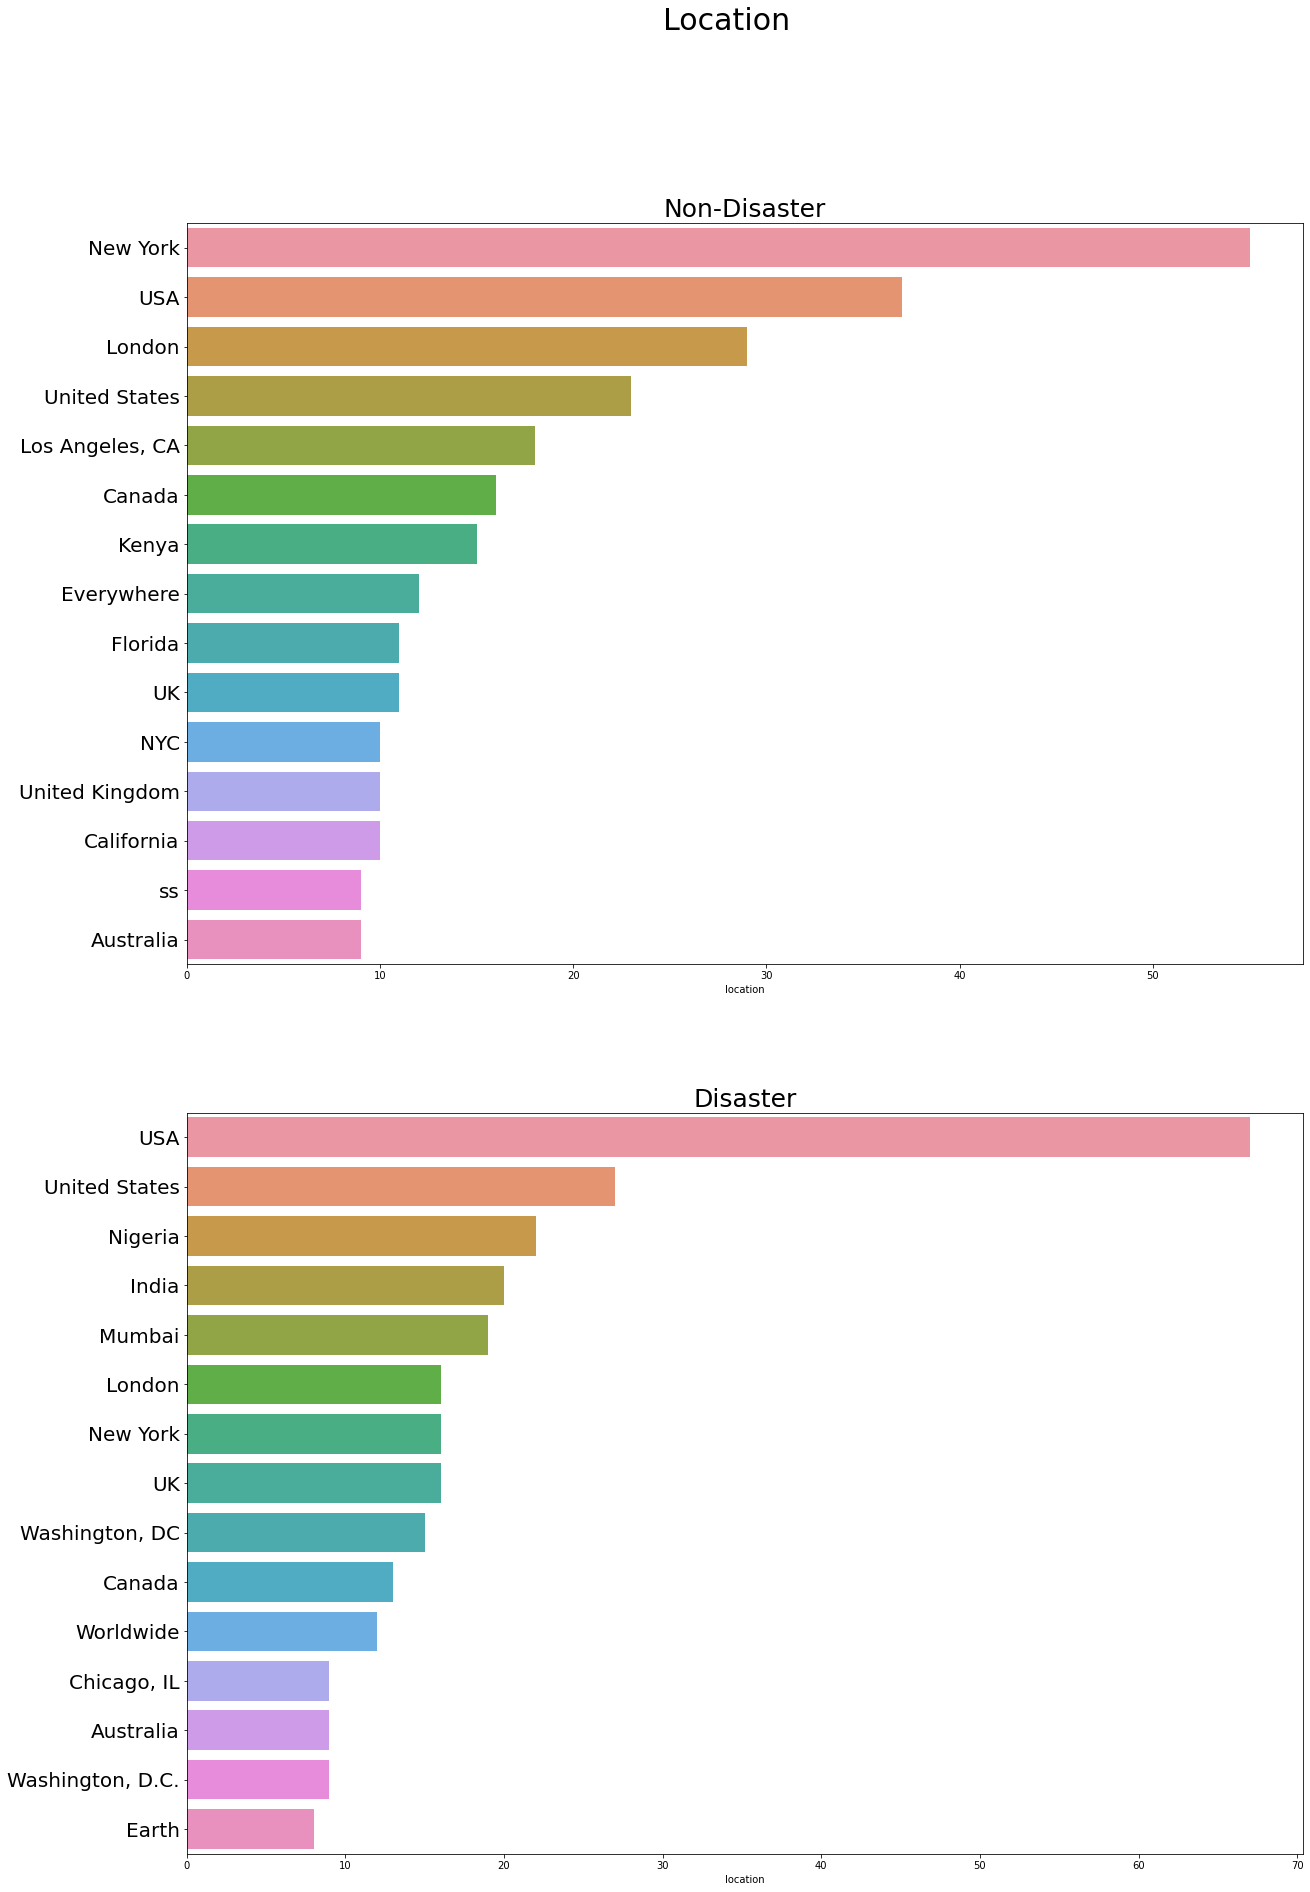

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Location',size=30)



sns.barplot(ax=axes[0],x=df_train[df_train['target']==0]['location'].value_counts()[:15],y=df_train[df_train['target']==0]['location'].value_counts()[:15].index)
axes[0].set_title('Non-Disaster',size=25)
y0=df_train[df_train['target']==0]['location'].value_counts()[:15].index
axes[0].set_yticklabels(y0, fontsize=20)

sns.barplot(ax=axes[1],x=df_train[df_train['target']==1]['location'].value_counts()[:15],y=df_train[df_train['target']==1]['location'].value_counts()[:15].index)
axes[1].set_title('Disaster',size=25)
y1=df_train[df_train['target']==1]['location'].value_counts()[:15].index
axes[1].set_yticklabels(y1, fontsize=20)


In [13]:
df_train[df_train['location']=='India'][['text','target']]

,text,target
51,Man wife get six years jail for setting ablaze...,1
162,OMG Horrible Accident Man Died in Wings of Air...,1
458,Militants attack police post in Udhampur; 2 SP...,1
1616,Ashes 4th Test: 10 Hilarious Twitter Reactions...,0
2186,MH370: Aircraft debris found on La Reunion is ...,1
2441,Madhya Pradesh Train Derailment: Village Youth...,1
2454,Madhya Pradesh Train Derailment: Village Youth...,1
2458,Railway Minister Prabhu calls MP derailment a ...,1
2463,25 killed 50 injured in Madhya Pradesh twin tr...,1
2465,Trains derailment: 'It's the freakiest of frea...,1


In [14]:
list(set(df_train['keyword']))==list(set(df_test['keyword']))

True

<AxesSubplot:xlabel='keyword'>

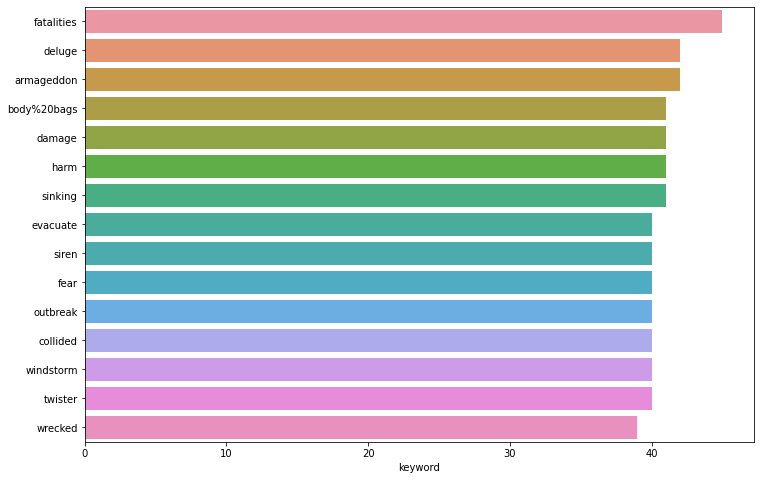

In [15]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_train['keyword'].value_counts()[:15],y=df_train['keyword'].value_counts()[:15].index)

In [16]:
df_train[df_train['target']==0]['keyword'].value_counts()

body%20bags          40
armageddon           37
harm                 37
wrecked              36
ruin                 36
                     ..
suicide%20bombing     1
suicide%20bomber      1
oil%20spill           1
outbreak              1
typhoon               1
Name: keyword, Length: 218, dtype: int64

[Text(0, 0, 'body%20bags'),
 Text(0, 1, 'armageddon'),
 Text(0, 2, 'harm'),
 Text(0, 3, 'wrecked'),
 Text(0, 4, 'ruin'),
 Text(0, 5, 'deluge'),
 Text(0, 6, 'twister'),
 Text(0, 7, 'siren'),
 Text(0, 8, 'fear'),
 Text(0, 9, 'explode'),
 Text(0, 10, 'panic'),
 Text(0, 11, 'screaming'),
 Text(0, 12, 'aftershock'),
 Text(0, 13, 'blizzard'),
 Text(0, 14, 'blazing'),
 Text(0, 15, 'traumatised'),
 Text(0, 16, 'sinking'),
 Text(0, 17, 'crush'),
 Text(0, 18, 'blaze'),
 Text(0, 19, 'curfew'),
 Text(0, 20, 'hellfire'),
 Text(0, 21, 'body%20bag'),
 Text(0, 22, 'upheaval'),
 Text(0, 23, 'bloody'),
 Text(0, 24, 'smoke'),
 Text(0, 25, 'electrocute'),
 Text(0, 26, 'collide'),
 Text(0, 27, 'panicking'),
 Text(0, 28, 'blew%20up'),
 Text(0, 29, 'sunk')]

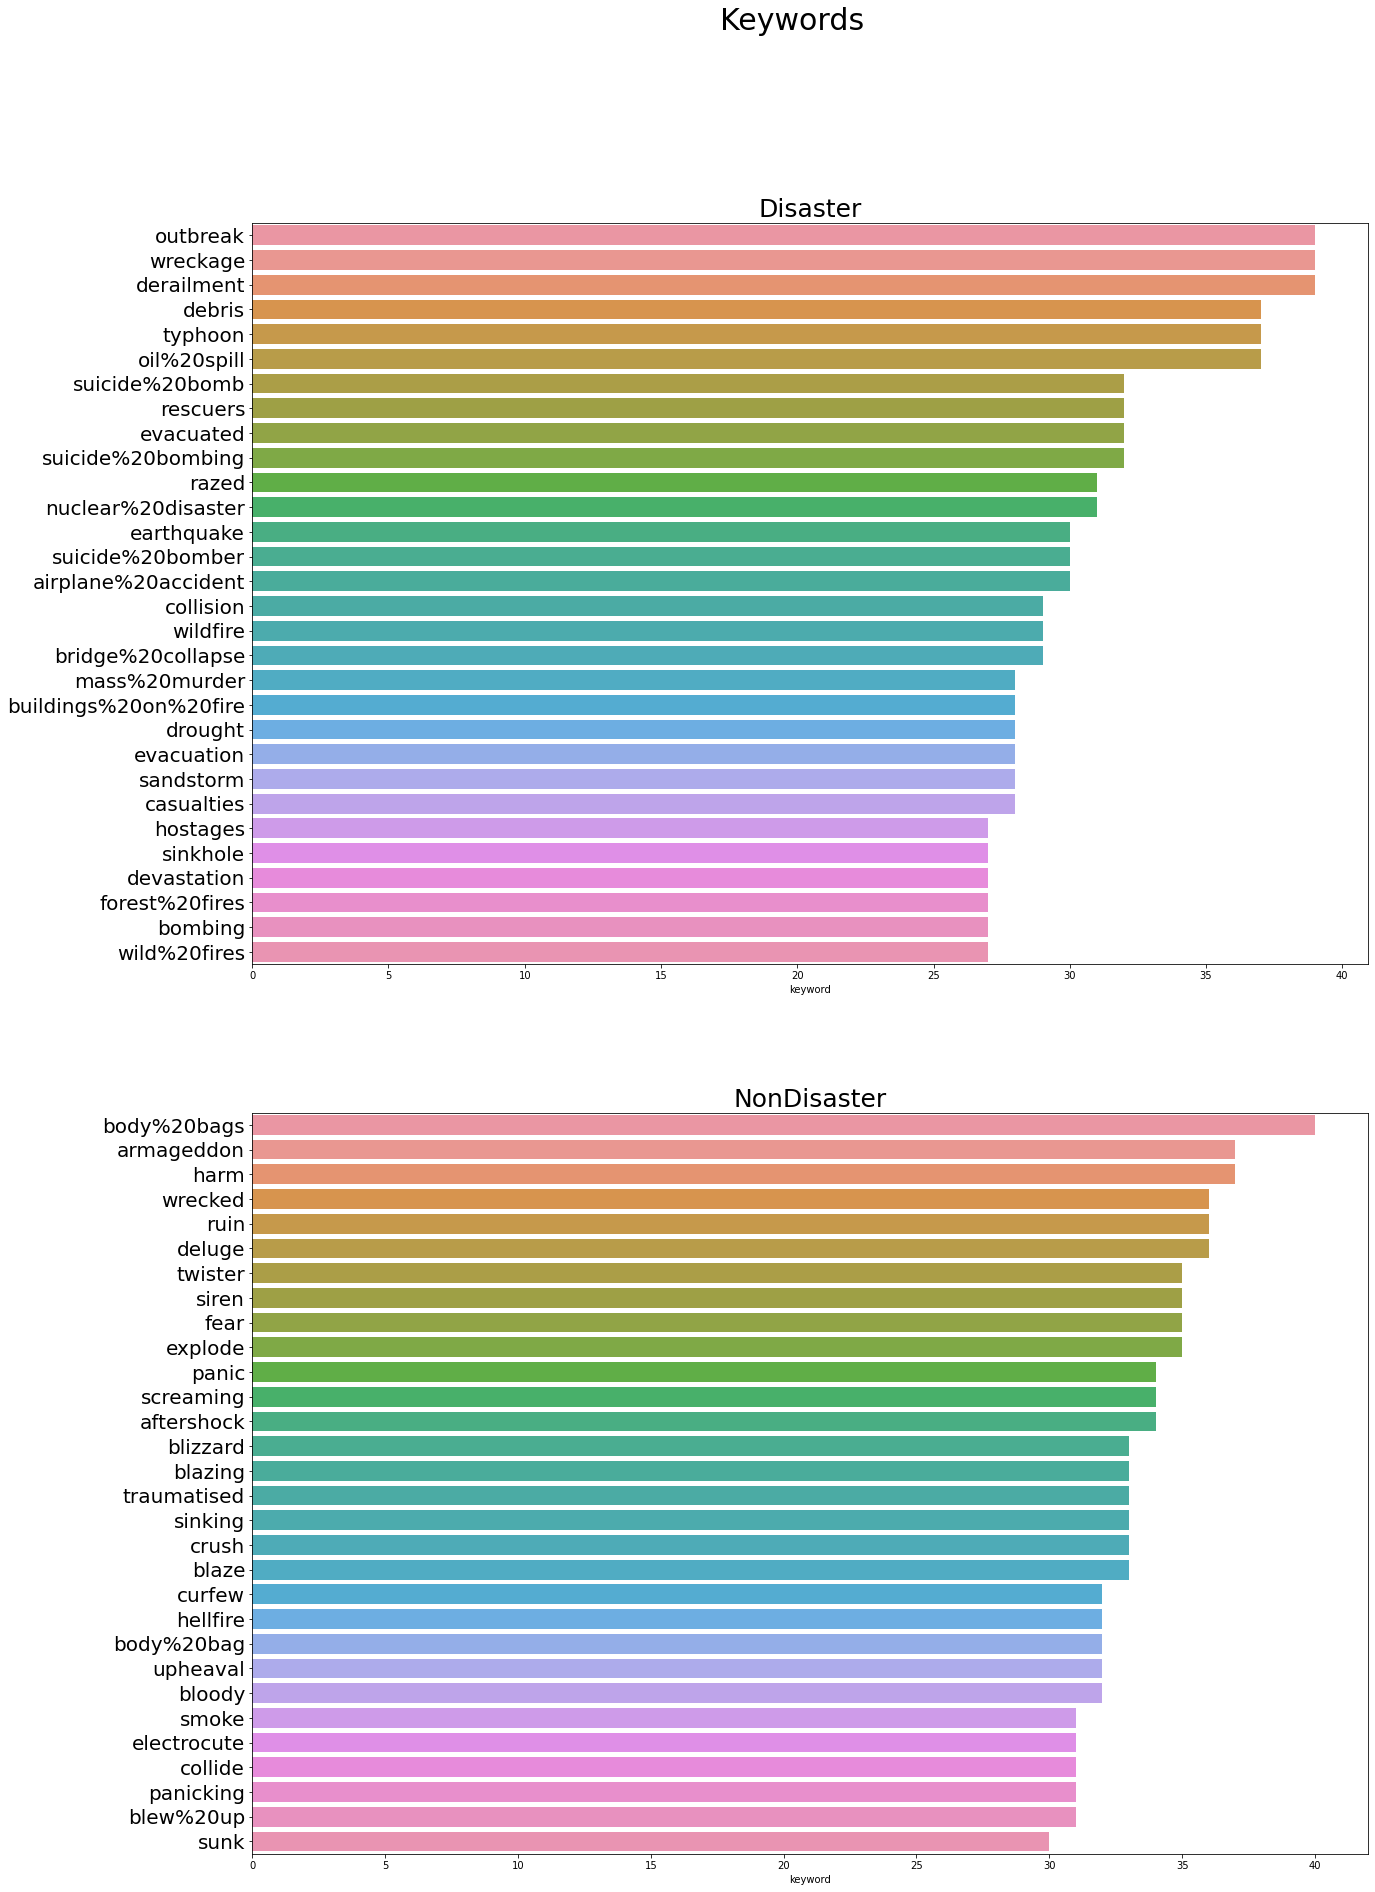

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Keywords',size=30)

sns.barplot(ax=axes[0],x=df_train[df_train['target']==1]['keyword'].value_counts()[:30],y=df_train[df_train['target']==1]['keyword'].value_counts()[:30].index)
axes[0].set_title('Disaster',size=25)
y0=df_train[df_train['target']==1]['keyword'].value_counts()[:30].index
axes[0].set_yticklabels(y0, fontsize=20)

sns.barplot(ax=axes[1],x=df_train[df_train['target']==0]['keyword'].value_counts()[:30],y=df_train[df_train['target']==0]['keyword'].value_counts()[:30].index)
axes[1].set_title('NonDisaster',size=25)
y1=df_train[df_train['target']==0]['keyword'].value_counts()[:30].index
axes[1].set_yticklabels(y1, fontsize=20)


In [18]:
df_train.loc[2,'text']

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

<AxesSubplot:ylabel='Density'>

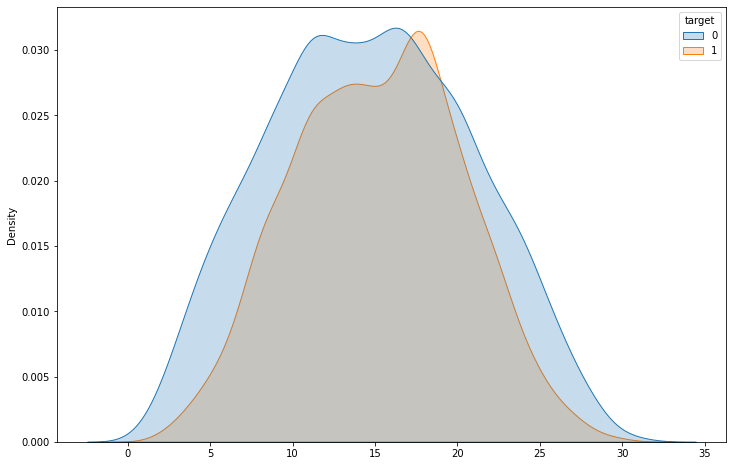

In [19]:
word_length=[]
for i in df_train['text']:
    word_length.append(len(i.split()))
    
plt.figure(figsize=(12,8))
sns.kdeplot(word_length,hue=df_train['target'],fill=True)

In [20]:
lemma=WordNetLemmatizer()
cv=CountVectorizer(ngram_range=(1,2),max_features=10000)

# Porter Stemmer or Snowball Stemmer can also be used instead of Wordnet lemmatizer and tfidf or hashing vectorizer can also be used in place of count vectorizer

In [21]:

def most_freqent_words(data=df_train,target=1,n=15,n_grams=1):
    corpus=[]
    
    for i in df_train[df_train['target']==target]['text']:
        review=re.sub(r'https?://\S+|www\.\S+','',i)
        review=re.sub(r'<.*?>','',review)
        review=re.sub('[^a-zA-Z]',' ',review)
        review=review.lower()
        review=review.split()
        review=[lemma.lemmatize(word) for word in review if not word in stopwords.words('english')]
        review=' '.join(review)
        corpus.append(review)
        
    vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    top_words=[]
    top_freq=[]
    for word, freq in words_freq[:n]:
        top_words.append(word)
        top_freq.append(freq)
        
    return top_words,top_freq

## Most Frequent Unigrams

[Text(0, 0, 'like'),
 Text(0, 1, 'amp'),
 Text(0, 2, 'get'),
 Text(0, 3, 'new'),
 Text(0, 4, 'one'),
 Text(0, 5, 'body'),
 Text(0, 6, 'time'),
 Text(0, 7, 'day'),
 Text(0, 8, 'video'),
 Text(0, 9, 'would'),
 Text(0, 10, 'via'),
 Text(0, 11, 'love'),
 Text(0, 12, 'people'),
 Text(0, 13, 'go'),
 Text(0, 14, 'know')]

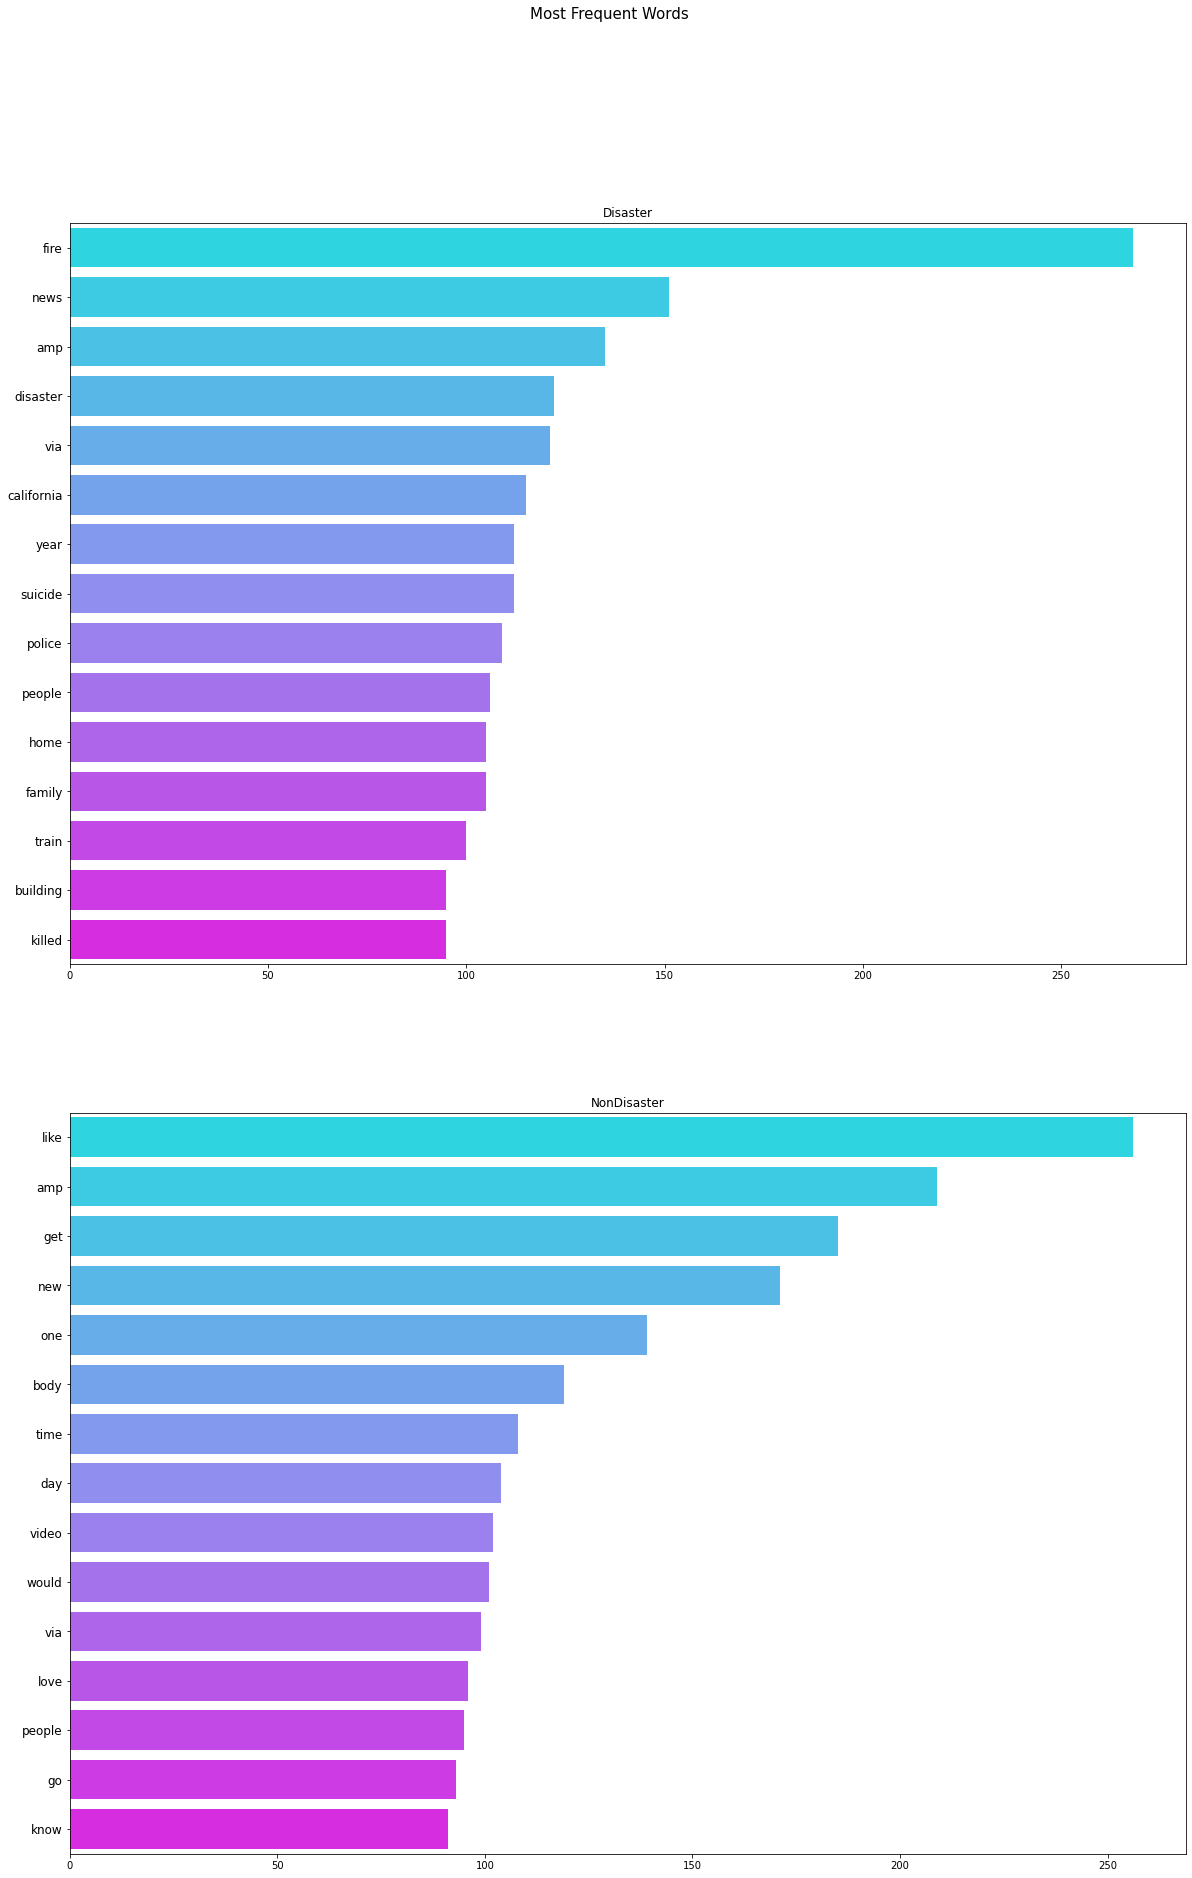

In [22]:
words1,freq1=most_freqent_words(target=1,n=15,n_grams=1)
words0,freq0=most_freqent_words(target=0,n=15,n_grams=1)

fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Most Frequent Words',size=15)

sns.barplot(ax=axes[0],y=words1,x=freq1,palette='cool')
axes[0].set_title('Disaster')
axes[0].set_yticklabels(words1,fontsize=12)

sns.barplot(ax=axes[1],y=words0,x=freq0,palette='cool')
axes[1].set_title('NonDisaster')
axes[1].set_yticklabels(words0,fontsize=12)



## Most Frequent Bigrams

[Text(0, 0, 'body bag'),
 Text(0, 1, 'cross body'),
 Text(0, 2, 'youtube video'),
 Text(0, 3, 'liked youtube'),
 Text(0, 4, 'look like'),
 Text(0, 5, 'gt gt'),
 Text(0, 6, 'full read'),
 Text(0, 7, 'feel like'),
 Text(0, 8, 'body bagging'),
 Text(0, 9, 'burning building'),
 Text(0, 10, 'reddit quarantine'),
 Text(0, 11, 'quarantine offensive'),
 Text(0, 12, 'offensive content'),
 Text(0, 13, 'content policy'),
 Text(0, 14, 'loud bang')]

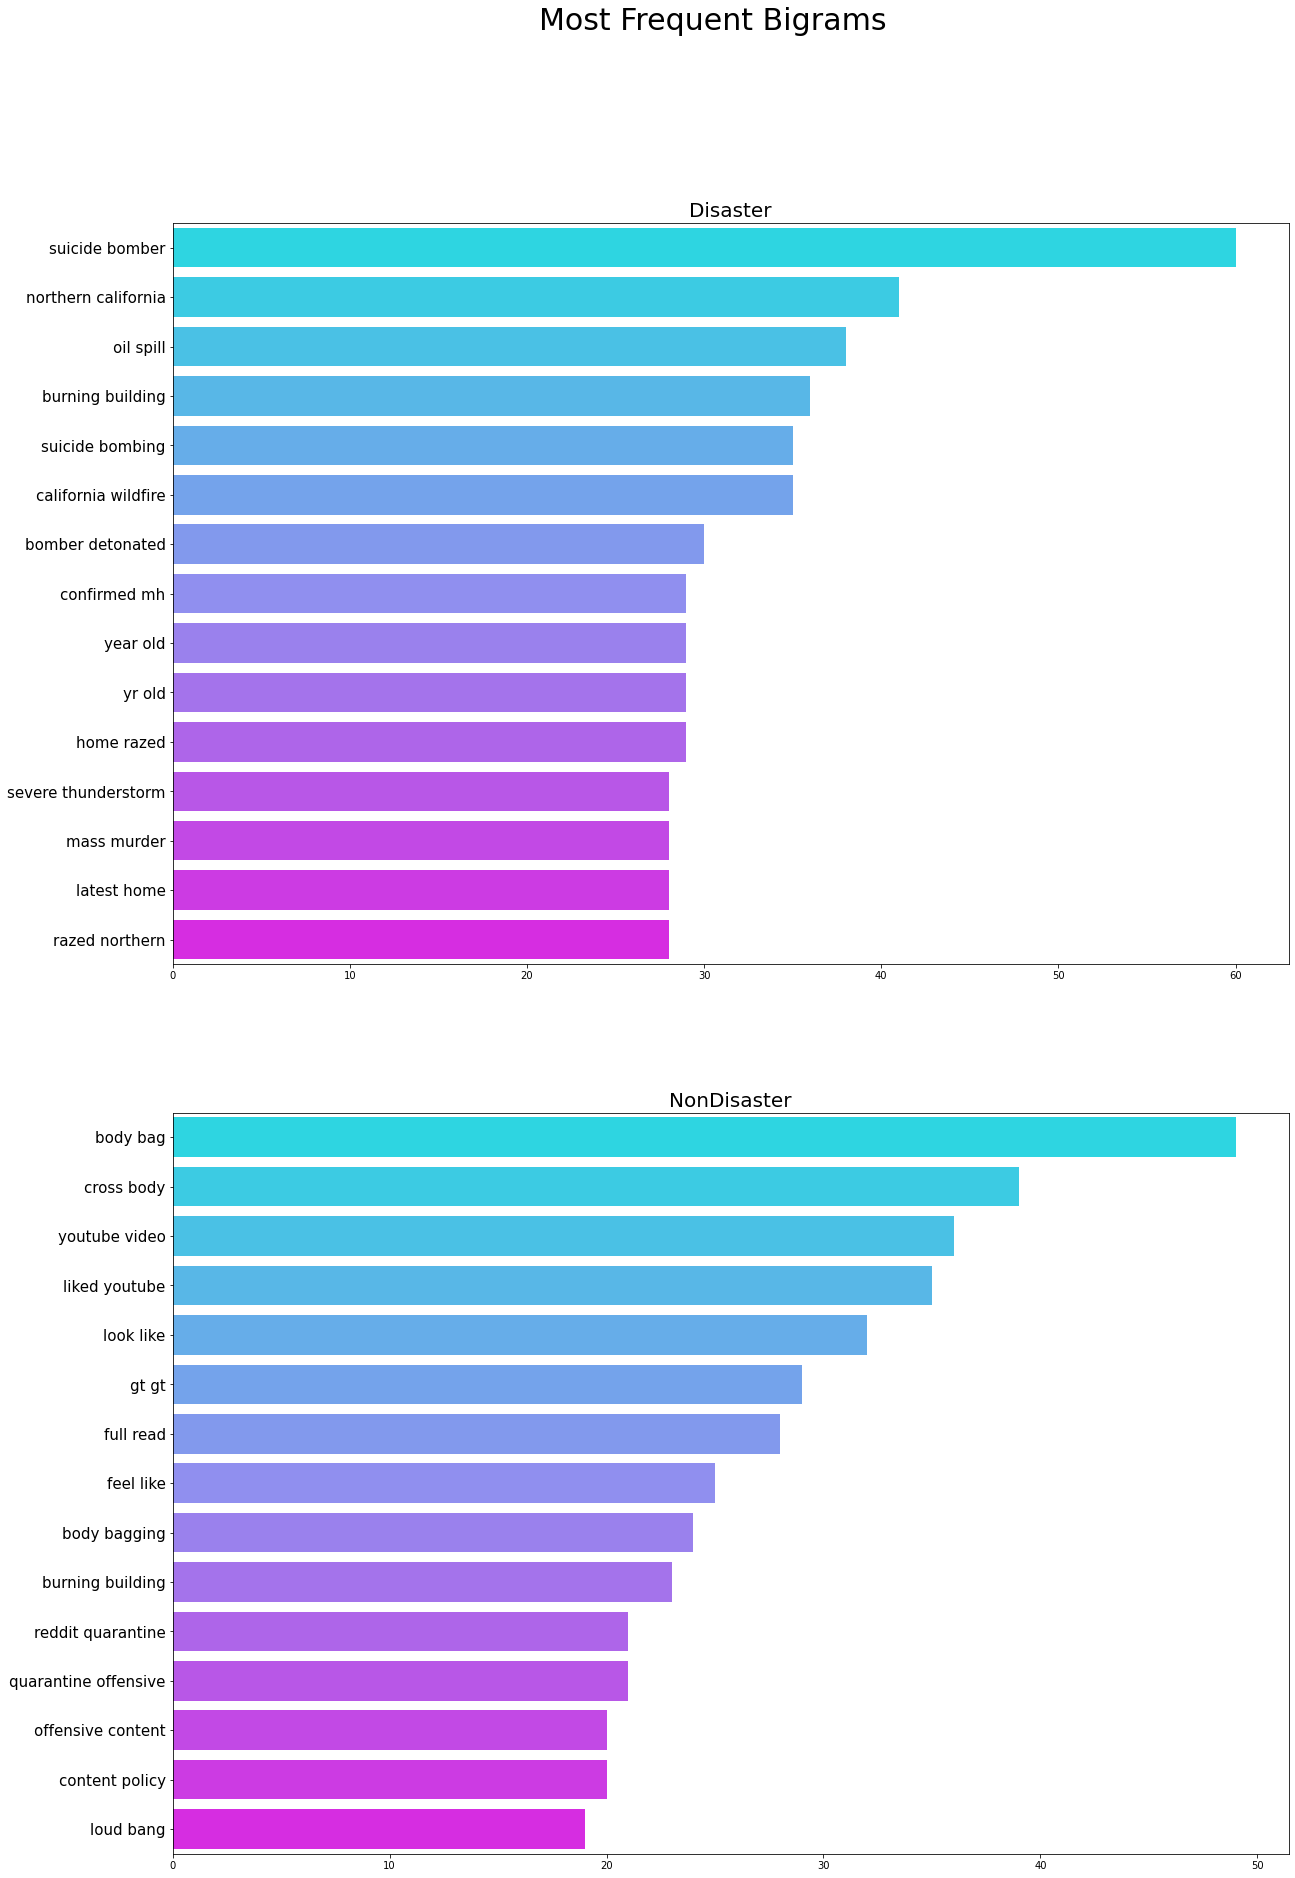

In [23]:
words1,freq1=most_freqent_words(target=1,n=15,n_grams=2)
words0,freq0=most_freqent_words(target=0,n=15,n_grams=2)

fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Most Frequent Bigrams',size=30)

sns.barplot(ax=axes[0],y=words1,x=freq1,palette='cool')
axes[0].set_title('Disaster',size=20)
axes[0].set_yticklabels(words1,fontsize=15)

sns.barplot(ax=axes[1],y=words0,x=freq0,palette='cool')
axes[1].set_title('NonDisaster',size=20)
axes[1].set_yticklabels(words0,fontsize=15)



## Most Frequent Trigrams

[Text(0, 0, 'liked youtube video'),
 Text(0, 1, 'cross body bag'),
 Text(0, 2, 'reddit quarantine offensive'),
 Text(0, 3, 'quarantine offensive content'),
 Text(0, 4, 'pick fan army'),
 Text(0, 5, 'reddit new content'),
 Text(0, 6, 'new content policy'),
 Text(0, 7, 'china stock market'),
 Text(0, 8, 'stock market crash'),
 Text(0, 9, 'full read ebay'),
 Text(0, 10, 'ignition knock detonation'),
 Text(0, 11, 'knock detonation sensor'),
 Text(0, 12, 'content policy go'),
 Text(0, 13, 'policy go effect'),
 Text(0, 14, 'go effect many')]

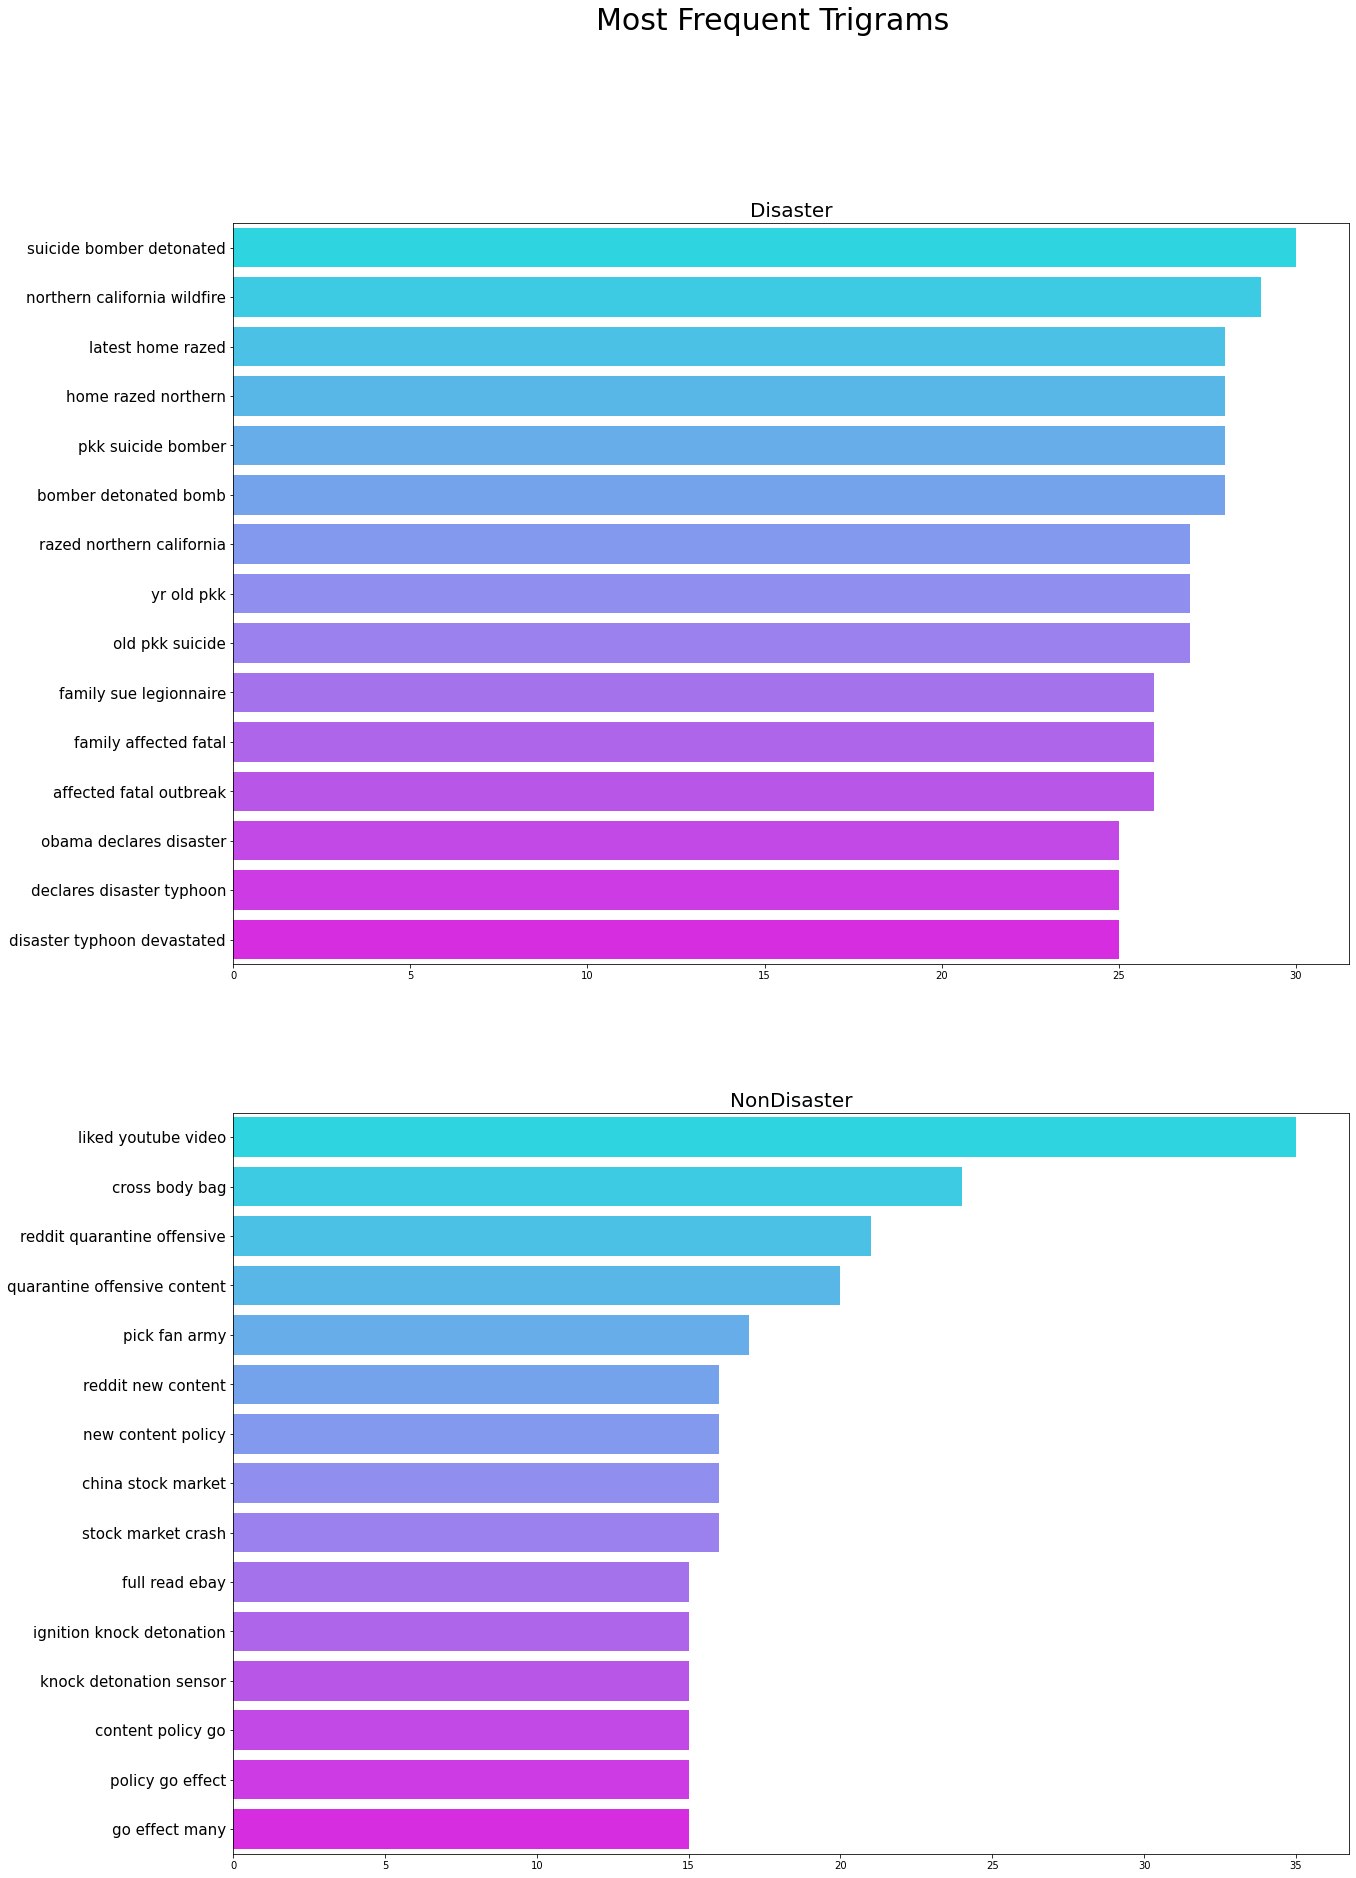

In [24]:
words1,freq1=most_freqent_words(target=1,n=15,n_grams=3)
words0,freq0=most_freqent_words(target=0,n=15,n_grams=3)

fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Most Frequent Trigrams',size=30)

sns.barplot(ax=axes[0],y=words1,x=freq1,palette='cool')
axes[0].set_title('Disaster',size=20)
axes[0].set_yticklabels(words1,fontsize=15)

sns.barplot(ax=axes[1],y=words0,x=freq0,palette='cool')
axes[1].set_title('NonDisaster',size=20)
axes[1].set_yticklabels(words0,fontsize=15)



In [25]:
corpus=[]
for i in range(len(df_train)):
    review=re.sub(r'https?://\S+|www\.\S+','',df_train.loc[i,'text'])
    review=re.sub(r'<.*?>','',review)
    review=re.sub('[^a-zA-Z]',' ',review)
    review=review.lower()
    review=review.split()
    review=[lemma.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

In [26]:
print(corpus[0])
df_train.loc[0,'text']

deed reason earthquake may allah forgive u


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

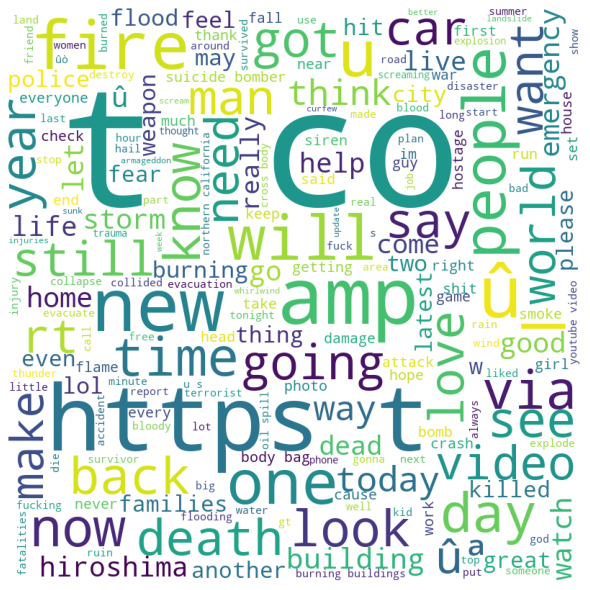

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)
 
for val in df_train.text:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Basic models

##### This book is aimed at providing the clarity on the implementation of different models and so hyperparameter tuning is not done for any of the models.

In [28]:
x=cv.fit_transform(corpus).toarray()
y=df_train['target']

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=2020,test_size=0.2)

In [30]:
model=LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [31]:
cross_val_score(model,x,y,cv=5,scoring='f1')

array([0.60902978, 0.52622528, 0.58299595, 0.50283554, 0.69009585])

Test Accuracy: 0.8030203545633617
Test Confusion Matrix: [[747 198]
 [102 476]]


0.7603833865814696

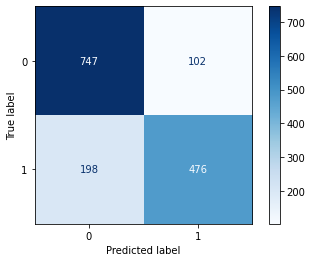

In [32]:
print('Test Accuracy:',accuracy_score(model.predict(x_test),y_test))
print('Test Confusion Matrix:',confusion_matrix(model.predict(x_test),y_test))
plot_confusion_matrix(model, x_test, y_test,cmap='Blues')  
f1_score(y_test,model.predict(x_test))

Train Accuracy: 0.9425287356321839
Train Confusion Matrix: [[3426  283]
 [  67 2314]]


0.9296906388107673

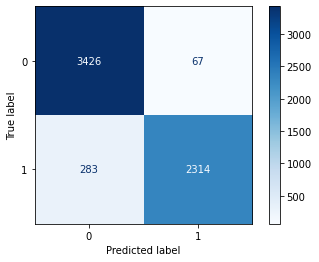

In [33]:
print('Train Accuracy:',accuracy_score(model.predict(x_train),y_train))
print('Train Confusion Matrix:',confusion_matrix(model.predict(x_train),y_train))
plot_confusion_matrix(model, x_train, y_train,cmap='Blues')  
f1_score(y_train,model.predict(x_train))

In [34]:
xgb=XGBClassifier(max_depth=3,learning_rate=0.2)

In [35]:
xgb.fit(x_train,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:04:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
cross_val_score(xgb,x,y,cv=5,scoring='f1')

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:05:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:07:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:08:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:10:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:11:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.45695364, 0.36511156, 0.42585551, 0.32438479, 0.49287169])

Test Accuracy: 0.7458962573867367
Test Confusion Matrix: 
 [[794 332]
 [ 55 342]]
Train Accuracy: 0.7827586206896552
Train Confusion Matrix:
 [[3319 1149]
 [ 174 1448]]


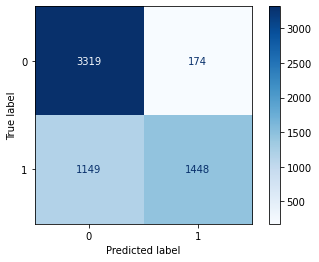

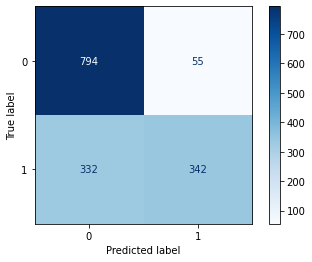

In [37]:
print('Test Accuracy:',accuracy_score(xgb.predict(x_test),y_test))
print('Test Confusion Matrix: \n',confusion_matrix(xgb.predict(x_test),y_test))
plot_confusion_matrix(xgb, x_train, y_train,cmap='Blues')  
print('Train Accuracy:',accuracy_score(xgb.predict(x_train),y_train))
print('Train Confusion Matrix:\n',confusion_matrix(xgb.predict(x_train),y_train))
plot_confusion_matrix(xgb, x_test, y_test,cmap='Blues')  

In [38]:
f1_score(xgb.predict(x_test),y_test)

0.6386554621848739

##### Better results for xgboost and logistic regression could be obtained by hyperparameter tuning using GridSearch or Random Search. Grid Search and Random Search will take time for hyperparameter optimization though.

## Deep Learning Model

In [39]:
model=tf.keras.Sequential([tf.keras.layers.Dense(32,input_shape=[10000],activation='relu'),
                         tf.keras.layers.Dense(32,activation='relu'),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(32,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(1,activation='sigmoid')])
opt=Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)

Hyperparameter optimization of optuna can be done using Optuna. If interested you can refer this:[https://medium.com/optuna/using-optuna-to-optimize-tensorflow-hyperparameters-57b6d4d316a2](https://medium.com/optuna/using-optuna-to-optimize-tensorflow-hyperparameters-57b6d4d316a2)

In [40]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=100)

Epoch 1/20
61/61 [==============================] - 3s 19ms/step - loss: 0.6762 - accuracy: 0.5775 - val_loss: 0.5652 - val_accuracy: 0.7919
Epoch 2/20
61/61 [==============================] - 0s 8ms/step - loss: 0.4709 - accuracy: 0.8445 - val_loss: 0.4435 - val_accuracy: 0.8063
Epoch 3/20
61/61 [==============================] - 1s 8ms/step - loss: 0.2710 - accuracy: 0.9070 - val_loss: 0.5191 - val_accuracy: 0.7945
Epoch 4/20
61/61 [==============================] - 0s 8ms/step - loss: 0.1781 - accuracy: 0.9466 - val_loss: 0.6396 - val_accuracy: 0.7879
Epoch 5/20
61/61 [==============================] - 0s 8ms/step - loss: 0.1161 - accuracy: 0.9636 - val_loss: 0.7652 - val_accuracy: 0.7768
Epoch 6/20
61/61 [==============================] - 0s 8ms/step - loss: 0.0928 - accuracy: 0.9669 - val_loss: 0.8474 - val_accuracy: 0.7669
Epoch 7/20
61/61 [==============================] - 0s 8ms/step - loss: 0.0857 - accuracy: 0.9711 - val_loss: 1.0015 - val_accuracy: 0.7702
Epoch 8/20
61/61 [=

In [41]:
f1_score(model.predict_classes(x_test),y_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.728787878787879

## LSTM

##### Whenever we talk about the sequences it is must that we know about LSTMs,GRUs and RNNs. There is no point in jumping directly to the implementation of transformers without having the knowledge about the evolution of transformer models and for that knowing about the RNNs and how their drawbacks led to creation of GRUs and LSTMs whose drawbacks further led to the attention models and finally the transformers.

In [42]:
voc_size=10000

In [43]:
onehot=[one_hot(words,voc_size) for words in corpus]

In [44]:
lengths=[len(i) for i in onehot]
max(lengths)

25

In [45]:
sent_len=30
embedded_docs=pad_sequences(onehot,padding='pre',maxlen=sent_len)
embedded_docs

array([[   0,    0,    0, ..., 6694, 9407, 8877],
       [   0,    0,    0, ..., 2624, 8465, 9152],
       [   0,    0,    0, ..., 3896, 2270, 4014],
       ...,
       [   0,    0,    0, ..., 1945, 6156, 1602],
       [   0,    0,    0, ..., 8195, 6221, 7998],
       [   0,    0,    0, ..., 6241, 9360, 9485]], dtype=int32)

In [46]:
embedding_vec_features=60
model=tf.keras.Sequential([tf.keras.layers.Embedding(voc_size,embedding_vec_features,input_length=sent_len),
                         tf.keras.layers.LSTM(100),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(32,activation='relu'),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(64,activation='relu'),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(1,activation='sigmoid')])
opt=Adam(learning_rate=0.0005)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics='accuracy')

##### Again this notebook is created to just give a walkthrough of implementation of different models. The hyperparameter tuning for this model can be done using Optuna. You can use the above given link for refernce and try out optuna for yourself.

In [47]:
x_final=np.array(embedded_docs[:len(df_train)])
y_final=np.array(y)

In [48]:
x_train,x_test,y_train,y_test=train_test_split(x_final,y_final,random_state=2021,test_size=0.2)

In [49]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=10)

Epoch 1/10
191/191 [==============================] - 5s 14ms/step - loss: 0.6787 - accuracy: 0.5728 - val_loss: 0.5095 - val_accuracy: 0.7584
Epoch 2/10
191/191 [==============================] - 2s 11ms/step - loss: 0.4116 - accuracy: 0.8331 - val_loss: 0.4532 - val_accuracy: 0.7905
Epoch 3/10
191/191 [==============================] - 2s 11ms/step - loss: 0.2865 - accuracy: 0.9021 - val_loss: 0.5045 - val_accuracy: 0.7846
Epoch 4/10
191/191 [==============================] - 2s 11ms/step - loss: 0.2024 - accuracy: 0.9301 - val_loss: 0.6021 - val_accuracy: 0.7649
Epoch 5/10
191/191 [==============================] - 2s 11ms/step - loss: 0.1489 - accuracy: 0.9539 - val_loss: 0.7541 - val_accuracy: 0.7617
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.1102 - accuracy: 0.9617 - val_loss: 0.8098 - val_accuracy: 0.7472
Epoch 7/10
191/191 [==============================] - 2s 11ms/step - loss: 0.0827 - accuracy: 0.9729 - val_loss: 0.9376 - val_accuracy: 0.7400

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 60)            600000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               64400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [51]:
f1_score(y_test,model.predict_classes(x_test))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7040816326530611

## Transformer Model

##### Transformers are changing the whole course of NLP achieving SOTA(state of the Art) results. Attention models are a good place to start when learning about transformers. The birth of attention models manoeuvred the NLP field in a different direction and for the better. These attention models have a great limitation when working with long sequences, their ability to retain information from the first elements was lost when new elements were incorporated into the sequence. Hence this led to the evolution of transformers. For understanding transformers it is great to start with the paper "Attention is all you need". Link will be given below. But honestly I did not understand the concept of transformers after reading the paper even after several attempts. Then I came across a wonderful blog by Jay Alammar that explained clearly in a step by step manner the working of the transformer. I highly recommend this blog to anyone who is interested in understanding the working of transformers.

##### Attention models paper:[Attention Model](https://arxiv.org/pdf/1409.0473.pdf)
##### Refer to this video for better understanding of attention models:[https://www.youtube.com/watch?v=fdhojC37_Co&list=PLZoTAELRMXVMdJ5sqbCK2LiM0HhQVWNzm&index=28](https://www.youtube.com/watch?v=fdhojC37_Co&list=PLZoTAELRMXVMdJ5sqbCK2LiM0HhQVWNzm&index=28)
##### The link for transformer paper: [Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
##### Jay Alammar's blog: [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)


In [52]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [53]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [54]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [55]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [56]:
train_input = bert_encode(df_train.text.values, tokenizer,max_len=160)
test_input = bert_encode(df_test.text.values, tokenizer,max_len=160)
train_labels = df_train.target.values

In [57]:
model = build_model(bert_layer,max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [58]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/5
381/381 [==============================] - 410s 992ms/step - loss: 0.4831 - accuracy: 0.7774 - val_loss: 0.3715 - val_accuracy: 0.8457
Epoch 2/5
381/381 [==============================] - 375s 985ms/step - loss: 0.2701 - accuracy: 0.8953 - val_loss: 0.3680 - val_accuracy: 0.8483
Epoch 3/5
381/381 [==============================] - 375s 985ms/step - loss: 0.1375 - accuracy: 0.9510 - val_loss: 0.4937 - val_accuracy: 0.8207
Epoch 4/5
381/381 [==============================] - 376s 986ms/step - loss: 0.0728 - accuracy: 0.9733 - val_loss: 0.6050 - val_accuracy: 0.8418
Epoch 5/5
381/381 [==============================] - 376s 987ms/step - loss: 0.0433 - accuracy: 0.9834 - val_loss: 0.6628 - val_accuracy: 0.8372


##### There are many transformer models such as BERT,ALBERT,DistilBERT,ROBERTa,GPT3,just to name a few. There's no specific reason as to why I chose BERT over others. This blog might be helpful in understanding [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270). You can try out the other models from [tensorflow hub](https://tfhub.dev/google/collections/transformer_encoders_text/1) There are many notebooks on implementation of Bert and I found this one easy and simple. Total credit for transformer model goes to [Disaster NLP: Keras BERT using TFHub](https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub) 

## Submission

In [59]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [60]:
submission=pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)